In [1]:
# --- 1. Imports & setup ---
import os
import sqlite3
from PIL import Image
import imagehash
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Dossier d'images de référence (une carte par image)
REF_DIR = "reference_images/mega-evolution/fr-fr"  # à adapter à ton chemin
DB_PATH = "database.db"
HASH_TYPE = "phash"  # 'phash', 'dhash', 'ahash', 'whash'
HASH_SIZE = 16

In [3]:
# --- 2. Utility functions ---

def compute_hash(pil_img, hash_type="phash", hash_size=16):
    """Calcule un hash perceptuel à partir d'une image PIL."""
    if hash_type == "phash":
        return str(imagehash.phash(pil_img, hash_size=hash_size))
    if hash_type == "dhash":
        return str(imagehash.dhash(pil_img, hash_size=hash_size))
    if hash_type == "ahash":
        return str(imagehash.average_hash(pil_img, hash_size=hash_size))
    if hash_type == "whash":
        return str(imagehash.whash(pil_img, hash_size=hash_size))
    raise ValueError("Type de hash inconnu")

def init_db(path):
    con = sqlite3.connect(path)
    cur = con.cursor()
    cur.execute("""
        CREATE TABLE IF NOT EXISTS cards (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            file_name TEXT,
            hash TEXT
        )
    """)
    con.commit()
    con.close()

In [4]:
# --- 3. Calcul des hashes ---
init_db(DB_PATH)

records = []
files = [f for f in os.listdir(REF_DIR) if f.lower().endswith((".png",".jpg",".jpeg"))]
for fn in tqdm(files, desc="Calcul des hashes"):
    path = os.path.join(REF_DIR, fn)
    try:
        img = Image.open(path).convert("RGB")
        img = img.resize((400, int(400 * img.height / img.width)))
        h = compute_hash(img, HASH_TYPE, HASH_SIZE)
        file_name = os.path.splitext(fn)[0]
        records.append((file_name, h))
    except Exception as e:
        print(f"Erreur {fn}:", e)

print(f"{len(records)} images traitées.")

Calcul des hashes: 100%|████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 138.00it/s]

188 images traitées.


In [5]:
# --- 4. Sauvegarde dans DB & DataFrame ---
con = sqlite3.connect(DB_PATH)
cur = con.cursor()
for file_name, h in records:
    cur.execute("INSERT INTO cards (file_name, hash) VALUES (?, ?)", (file_name, h))
con.commit()
con.close()

df = pd.DataFrame(records, columns=["file_name", "hash"])
df.head()

,file_name,hash
0,JL2G_FR_1,e1be69be541190d31aee36742ff987098fa02fa7c127cc...
1,JL2G_FR_10,bbef7aab14108416c438e469cfe68d56c7d44fd11bd13c...
2,JL2G_FR_100,811009bce05ee65f36679e31df02595b4dad45d55c8634...
3,JL2G_FR_101,afef7ec6545090715e38c30f6d8bec1bd42b387a9b5027...
4,JL2G_FR_102,aeb03eb854109056c4fe8bce9bced147d0522fb88f8ce5...


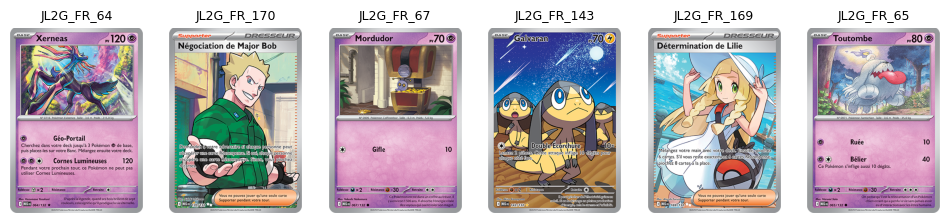

,file_name,hash
149,JL2G_FR_64,a7fb2ff95000d046dc562d963c9fd00fd88d5e9f8756e7...
79,JL2G_FR_170,a9ffd1cad0006434277a4aefcb3e70b2f61db169e3a49c...
152,JL2G_FR_67,eefb6e791012900652ae07fc95ec951e99017aa3ce71e6...
49,JL2G_FR_143,bbea3bbf2405ed47b1529295ca556a70ccd2d097c0c4cf...
77,JL2G_FR_169,c6ee91b358114cad1fed2f5a49830db6f2f5f6494a4a98...
150,JL2G_FR_65,8fff4fb44510d040f30a375bb2cbb44ebc453d27da3647...


In [6]:
# --- 5. Affichage échantillon ---
n = min(6, len(df))
sample = df.sample(n)

plt.figure(figsize=(12, 4))
for i, (_, row) in enumerate(sample.iterrows()):
    img = Image.open('reference_images/mega-evolution/fr-fr/'+row["file_name"]+'.png')
    plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.title(row["file_name"], fontsize=9)
    plt.axis("off")
plt.show()

sample

In [7]:
query_img = Image.open("test_images/test1.jpg").convert("RGB").resize((400, 300))
query_hash = compute_hash(query_img, HASH_TYPE, HASH_SIZE)

# Comparer au plus proche
con = sqlite3.connect(DB_PATH)
df_db = pd.read_sql("SELECT * FROM cards", con)
con.close()

df_db["distance"] = df_db["hash"].apply(lambda h: imagehash.hex_to_hash(h) - imagehash.hex_to_hash(query_hash))
df_db.sort_values("distance").head(5)

,id,file_name,hash,distance
9,10,JL2G_FR_107,82117e1b45109154d9be90a71efba7d153fa6f87998fcd...,106
170,171,JL2G_FR_83,c8ef78f61710930c2dcc6cc43eac363f97134bc7c1c3c3...,108
126,127,JL2G_FR_43,caff4b473501b40bf0b8c0f8c2f097d5978517af83eb8d...,110
10,11,JL2G_FR_108,e3e17afa14059d17cc1e683f6872c164c7e04f804b9ab6...,110
102,103,JL2G_FR_21,afff1e829401c11d62bc6abc1ae69c729f286f3ce507b5...,110
